In [1]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import (
    DataLoader,
    Dataset
)
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.models.lstm import ConvLSTMNet

In [2]:
warnings.filterwarnings("ignore")

#### **Data Preprocessing:**

In [3]:
def extract_frames(
    video_path: str,
    output_folder: str,
    frame_rate: int=1,
    skip_frames: bool=False
    ) -> list:
        if not os.path.exists(output_folder):
            os.makedirs(name=output_folder)
        cap=cv2.VideoCapture(filename=video_path)
        fps=int(cap.get(propId=cv2.CAP_PROP_FPS))
        frame_names=[]
        frame_count=0
        while cap.isOpened():
            ret, frame=cap.read()
            if not ret:
                break
            if skip_frames:
                if frame_count%(fps//frame_rate)==0:
                    video_name=re.search(
                        pattern="v_[^\\/]+(?=\\.)",
                        string=video_path
                    ).group(0)
                    frame_name=f"{video_name}_frame_{frame_count}.jpg"
                    frame_path=os.path.join(output_folder, frame_name)
                    cv2.imwrite(
                        filename=frame_path,
                        img=frame
                    )
                    frame_names.append(frame_name)
                    frame_count+=1
            else:
                video_name=re.search(
                    pattern="v_[^\\/]+(?=\\.)",
                    string=video_path
                ).group(0)
                frame_name=f"{video_name}_frame_{frame_count}.jpg"
                frame_path=os.path.join(output_folder, frame_name)
                cv2.imwrite(
                    filename=frame_path,
                    img=frame
                )
                frame_names.append(frame_name)
                frame_count+=1
        cap.release()
        return frame_names

In [4]:
def preprocess_frame(
    image_path: str,
    target_size: tuple=(64, 64)
) -> np.ndarray:
    image=Image.open(fp=image_path).resize(size=target_size)
    image_array=np.array(object=image)/255.0
    return image_array

In [5]:
input_folders=[r"data/videos/BreastStroke", r"data/videos/Kayaking", r"data/videos/Rafting", r"data/videos/Rowing", r"data/videos/Surfing"]
frame_folder=r"data/frames"
video_files=[]
for input_folder in input_folders:
    video_files.extend(
        os.listdir(input_folder)
    )
video_paths=[]
for input_folder in input_folders:
    video_files=os.listdir(input_folder)
    video_paths.extend([
        os.path.join(input_folder, video_file)
        for video_file in video_files
    ])
dataframe=pd.DataFrame(columns=["video_file", "frame_file"])
for video_path in tqdm(
    iterable=video_paths,
    desc="Extracting Frames",
    unit="video"
):
    video_file=os.path.basename(p=video_path)
    frame_paths=extract_frames(
        video_path=video_path,
        output_folder=frame_folder
    )
    for frame_path in frame_paths:
        dataframe=pd.concat(
            objs=[dataframe, pd.DataFrame(
                    data=[[video_file, frame_path]],
                    columns=["video_file", "frame_file"]
                )
            ],
            ignore_index=True
        )
dataframe["label"]=dataframe["video_file"].apply(lambda x: x.split("_")[1])
dataframe

Extracting Frames: 100%|██████████| 459/459 [06:50<00:00,  1.12video/s]


,video_file,frame_file,label
0,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_0.jpg,BreastStroke
1,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_1.jpg,BreastStroke
2,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_2.jpg,BreastStroke
3,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_3.jpg,BreastStroke
4,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_4.jpg,BreastStroke
...,...,...,...
102098,v_Surfing_g25_c04.avi,v_Surfing_g25_c04_frame_172.jpg,Surfing
102099,v_Surfing_g25_c04.avi,v_Surfing_g25_c04_frame_173.jpg,Surfing
102100,v_Surfing_g25_c04.avi,v_Surfing_g25_c04_frame_174.jpg,Surfing
102101,v_Surfing_g25_c04.avi,v_Surfing_g25_c04_frame_175.jpg,Surfing


In [6]:
sample_dataframe=dataframe.groupby(
    by="label",
    group_keys=False
).apply(lambda x: x[x["video_file"].isin(x["video_file"].unique()[:10])]).reset_index(drop=True)
sample_dataframe

,video_file,frame_file,label
0,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_0.jpg,BreastStroke
1,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_1.jpg,BreastStroke
2,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_2.jpg,BreastStroke
3,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_3.jpg,BreastStroke
4,v_BreastStroke_g01_c03.avi,v_BreastStroke_g01_c03_frame_4.jpg,BreastStroke
...,...,...,...
11590,v_Surfing_g03_c01.avi,v_Surfing_g03_c01_frame_120.jpg,Surfing
11591,v_Surfing_g03_c01.avi,v_Surfing_g03_c01_frame_121.jpg,Surfing
11592,v_Surfing_g03_c01.avi,v_Surfing_g03_c01_frame_122.jpg,Surfing
11593,v_Surfing_g03_c01.avi,v_Surfing_g03_c01_frame_123.jpg,Surfing


In [7]:
def filter_dataframe(
    video_files: pd.DataFrame,
    dataframe: pd.DataFrame
) -> pd.DataFrame:
    return dataframe[dataframe["video_file"].isin(values=video_files["video_file"])]

In [9]:
video_file_labels=sample_dataframe[["video_file", "label"]].drop_duplicates()
train_files, temporary_files=train_test_split(
    video_file_labels,
    test_size=0.2,
    stratify=video_file_labels["label"],
    random_state=42
)
validation_files, test_files=train_test_split(
    temporary_files,
    test_size=0.5,
    stratify=temporary_files["label"],
    random_state=42
)
train_set=filter_dataframe(
    video_files=train_files,
    dataframe=sample_dataframe
)
validation_set=filter_dataframe(
    video_files=validation_files,
    dataframe=sample_dataframe
)
test_set=filter_dataframe(
    video_files=test_files,
    dataframe=sample_dataframe
)
train_set=train_set.reset_index(drop=True)
validation_set=validation_set.reset_index(drop=True)
test_set=test_set.reset_index(drop=True)
tqdm.pandas()
train_set["prepared_frame"]=train_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
validation_set["prepared_frame"]=validation_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
test_set["prepared_frame"]=test_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
print("Training Set:", train_set["label"].value_counts())
print("Validation Set:", validation_set["label"].value_counts())
print("Test Set:", test_set["label"].value_counts())

  0%|          | 0/9097 [00:00<?, ?it/s]

100%|██████████| 1190/1190 [00:11<00:00, 101.83it/s]

Training Set: label
Rowing          2726
Surfing         1873
Kayaking        1584
Rafting         1568
BreastStroke    1346
Name: count, dtype: int64
Validation Set: label
Rowing          499
BreastStroke    261
Rafting         225
Kayaking        198
Surfing         125
Name: count, dtype: int64
Test Set: label
Rowing          386
Surfing         220
Rafting         213
Kayaking        187
BreastStroke    184
Name: count, dtype: int64


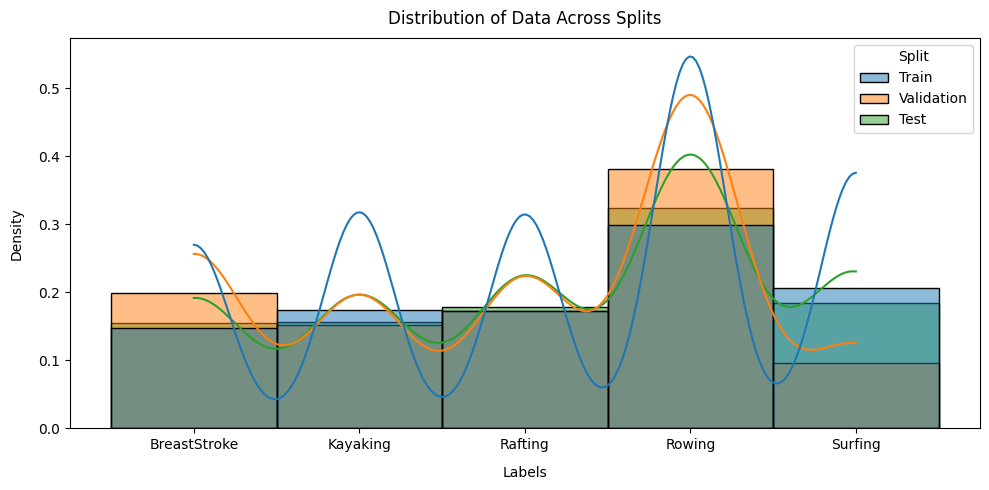

In [11]:
train_set["Split"]="Train"
validation_set["Split"]="Validation"
test_set["Split"]="Test"
combined_set=pd.concat(objs=[train_set, validation_set, test_set])
plt.figure(figsize=(10, 5))
sns.histplot(
    data=combined_set,
    x="label",
    hue="Split",
    stat="density",
    common_norm=False,
    kde=True,
    bins=20
)
plt.xlabel(
    xlabel="Labels",
    labelpad=10,
    fontdict={"fontsize": 10}
)
plt.ylabel(
    ylabel="Density",
    labelpad=10,
    fontdict={"fontsize": 10}
)
plt.title(
    label="Distribution of Data Across Splits",
    pad=10,
    fontdict={"fontsize": 12}
)
plt.tight_layout()
plt.show()
train_set=train_set.drop(columns="Split")
validation_set=validation_set.drop(columns="Split")
test_set=test_set.drop(columns="Split")

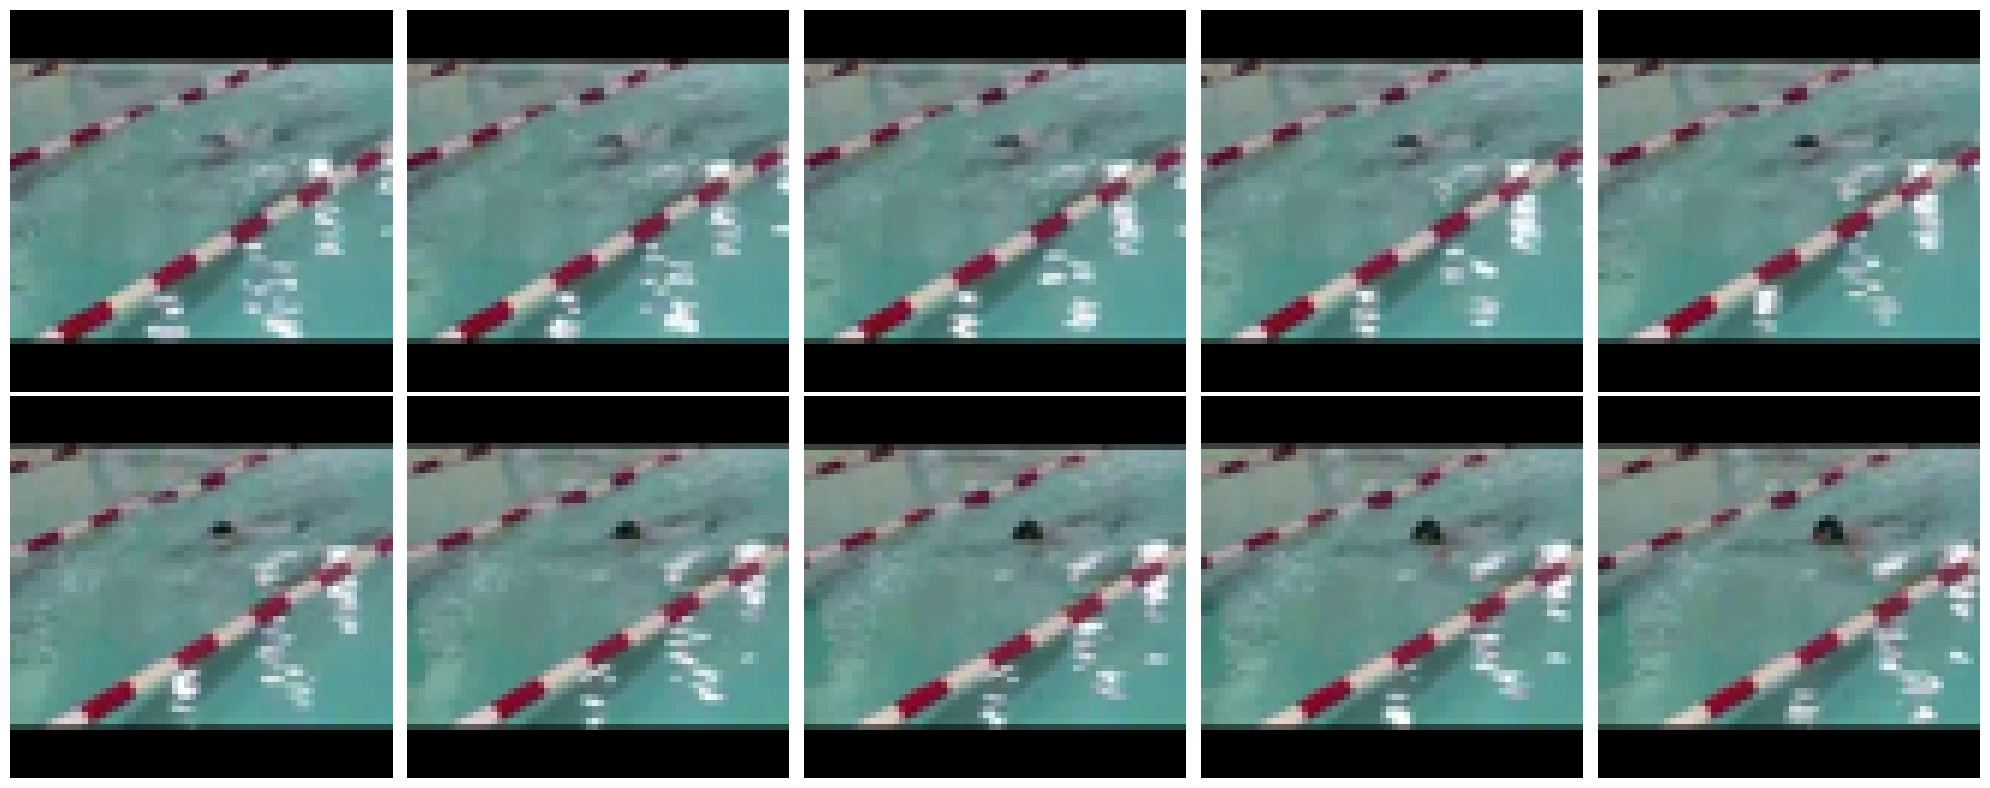

In [17]:
example_frames=train_set[train_set["video_file"]==train_set["video_file"][0]]["prepared_frame"].values
_, axes=plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(20, 8)
)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X=example_frames[i])
    ax.axis("off")
plt.tight_layout()
plt.show()

#### **Video Generation:**

In [18]:
def create_video(
    frames: list,
    video_path: str,
    fps: int=30
):
    frame_shape=frames[0].shape
    fourcc=cv2.VideoWriter_fourcc(*"mp4v")
    out=cv2.VideoWriter(
        filename=video_path,
        fourcc=fourcc,
        fps=fps,
        frameSize=(frame_shape[1], frame_shape[0]),
        isColor=True
    )
    for frame in tqdm(
        iterable=frames,
        desc="Creating Video",
        unit="frame"
    ):
        frame=(frame*255).astype(np.uint8)
        out.write(image=frame)
    out.release()

In [19]:
video_path=r"out/tests/example_video.mp4"
create_video(
    frames=example_frames,
    video_path=video_path
)

Creating Video: 100%|██████████| 96/96 [00:00<00:00, 5645.01frame/s]


#### **Batch Processing:**

In [23]:
class VideoDataset(Dataset):

    def __init__(
        self: None,
        dataframe: pd.DataFrame,
        sequence_length: int=11
    ) -> None:
        self.dataframe=dataframe
        self.sequence_length=sequence_length
        self.video_groups=dataframe.groupby(by="video_file")["prepared_frame"].apply(list)
        
    def __len__(self: None) -> int:
        return sum(len(frames)-self.sequence_length+1 for frames in self.video_groups if len(frames)>=self.sequence_length)
    
    def __getitem__(
        self: None,
        index: int
    ) -> tuple:
        cumulative_index=0
        for frames in self.video_groups:
            if len(frames)>=self.sequence_length:
                num_sequences=len(frames)-self.sequence_length+1
                if index<cumulative_index+num_sequences:
                    sequence_index=index-cumulative_index
                    sequence=frames[sequence_index:sequence_index+self.sequence_length]
                    sequence=torch.stack(tensors=[torch.tensor(
                            data=f,
                            dtype=torch.float32
                        ).permute(2, 0, 1) for f in sequence]
                    )
                    input_frames=sequence[:10]
                    target_frame=sequence[10]
                    return input_frames, target_frame
                cumulative_index+=num_sequences
        raise IndexError("Index out of bounds")

In [24]:
def collate_function(batch: list) -> tuple:
    input_frames, target_frames=zip(*batch)
    input_frames=torch.stack(tensors=input_frames)
    target_frames=torch.stack(tensors=target_frames)
    return input_frames, target_frames

In [25]:
train_dataset=VideoDataset(dataframe=train_set)
validation_dataset=VideoDataset(dataframe=validation_set)
test_dataset=VideoDataset(dataframe=test_set)
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_function
)
validation_loader=DataLoader(
    dataset=validation_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_function
)
test_loader=DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_function
)

### **Convolutional LSTM:**

In [26]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [27]:
n_channels=3
n_kernels=64
n_layers=2
kernel_size=3
padding=1
activation="relu"
frame_size=(64, 64)
model=ConvLSTMNet(
    n_channels=n_channels,
    n_kernels=n_kernels,
    n_layers=n_layers,
    kernel_size=kernel_size,
    padding=padding,
    activation=activation,
    frame_size=frame_size
).to(device)
model

ConvLSTMNet(
  (sequential): Sequential(
    (convlstm1): ConvLSTM(
      (convolutional_lstm_cell): ConvLSTMCell(
        (convolutional_layer): Conv2d(67, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm2): ConvLSTM(
      (convolutional_lstm_cell): ConvLSTMCell(
        (convolutional_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convolutional_layer): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [28]:
criterion=nn.MSELoss()
optimiser=Adam(
    params=model.parameters(),
    lr=0.001
)
scheduler=ReduceLROnPlateau(
    optimizer=optimiser,
    mode="min",
    patience=5,
    verbose=True
)

#### **Model Training:**

In [30]:
def train(
    model: nn.Module,
    criterion: nn.Module,
    optimiser: torch.optim.Optimizer,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    epochs: int,
    device: torch.device
) -> None:
    for epoch in tqdm(
        iterable=range(epochs),
        desc="Training",
        unit="epoch"
    ):
        model.train()
        train_loss=0.0
        for input_frames, target_frame in tqdm(
            iterable=train_loader,
            desc=f"Training Epoch {epoch+1}/{epochs}",
            unit="batch"
        ):
            input_frames=input_frames.permute(0, 2, 1, 3, 4).to(device)
            target_frame=target_frame.to(device)
            optimiser.zero_grad()
            output=model(input_frames)
            loss=criterion(output, target_frame)
            loss.backward()
            optimiser.step()
            train_loss+=loss.item()
        train_loss/=len(train_loader)
        model.eval()
        validation_loss=0.0
        with torch.no_grad():
            for input_frames, target_frame in tqdm(
                iterable=validation_loader,
                desc=f"Validation Epoch {epoch+1}/{epochs}",
                unit="batch"
            ):
                input_frames=input_frames.permute(0, 2, 1, 3, 4).to(device)
                target_frame=target_frame.to(device)
                output=model(input_frames)
                loss=criterion(output, target_frame)
                validation_loss+=loss.item()
            validation_loss/=len(validation_loader)
        scheduler.step(validation_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {validation_loss}")

In [ ]:
torch.cuda.empty_cache()
train(
    model=model,
    criterion=criterion,
    optimiser=optimiser,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=10,
    device=device
)

Training:  10%|█         | 1/10 [2:04:45<18:42:46, 7485.17s/epoch]

Epoch 1/10, Train Loss: 0.004045302435663282, Validation Loss: 0.0017364505285513588


Training:  20%|██        | 2/10 [3:30:45<13:35:40, 6117.60s/epoch]

Epoch 2/10, Train Loss: 0.0024104629483190365, Validation Loss: 0.0009676480429334333


Training:  30%|███       | 3/10 [6:25:22<15:45:56, 8108.10s/epoch]

Epoch 3/10, Train Loss: 0.002266551599913167, Validation Loss: 0.0014906962780514732


Training:  40%|████      | 4/10 [9:12:02<14:45:31, 8855.22s/epoch]

Epoch 4/10, Train Loss: 0.0020778170784230016, Validation Loss: 0.0012209522079501766


Training:  50%|█████     | 5/10 [12:20:51<13:32:15, 9747.07s/epoch]

Epoch 5/10, Train Loss: 0.002004907736537622, Validation Loss: 0.0009163940980215557


In [ ]:
model_path=r"out/models/conv_lstm_net.pth"
torch.save(
    obj=model.state_dict(),
    f=model_path
)

#### **Model Evaluation:**

In [ ]:
def evaluate(
    model: nn.Module,
    criterion: nn.Module,
    test_loader: DataLoader,
    device: torch.device
) -> float:
    model.eval()
    test_loss=0.0
    with torch.no_grad():
        for input_frames, target_frame in tqdm(
            iterable=test_loader,
            desc="Testing",
            unit="batch"
        ):
            input_frames=input_frames.permute(0, 2, 1, 3, 4).to(device)
            target_frame=target_frame.to(device)
            output=model(input_frames)
            loss=criterion(output, target_frame)
            test_loss+=loss.item()
        test_loss/=len(test_loader)
    return test_loss

In [ ]:
test_loss=evaluate(
    model=model,
    criterion=criterion,
    test_loader=test_loader,
    device=device
)
print(f"Test Loss: {test_loss}")

#### **Video Frame Prediction:**

In [ ]:
def generate_frames(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device
) -> list:
    model.eval()
    generated_frames=[]
    with torch.no_grad():
        for input_frames, _ in tqdm(
            iterable=data_loader,
            desc="Generating Frames",
            unit="batch"
        ):
            input_frames=input_frames.permute(0, 2, 1, 3, 4).to(device)
            output=model(input_frames)
            generated_frames.append(output.cpu().numpy())
    return generated_frames

In [ ]:
# generated_frames=generate_frames(
#     model=model,
#     data_loader=test_loader,
#     device=device
# )
# generated_frames=np.concatenate(
#     generated_frames,
#     axis=0
# )
# _, axes=plt.subplots(
#     nrows=2,
#     ncols=5,
#     figsize=(20, 8)
# )
# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(X=generated_frames[i][0])
#     ax.axis("off")
# plt.tight_layout()
# plt.show()

In [ ]:
# video_frames=[frame.transpose(1, 2, 0) for frame in generated_frames]
# video_path=r"out/results/generated_video.mp4"
# create_video(
#     frames=video_frames,
#     video_path=video_path
# )